# Analyse Objects

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/29
- update : 2024/03/07  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [25]:
# december 2023 w_2023_44
fileobjects_in = "objectTable_202312.csv"
fileobjects_out = "objectTableselected_202312.csv"
# Feb 2024 w_2024_07
fileobjects_in = "objectTable_202402.csv"
fileobjects_out = "objectTableselected_202402.csv"

In [3]:
#tract_selected = 5615
#patches_selected = [294, 313]


tract_selected = 3864
patches_selected = [236, 237]

In [4]:
suptitle = f"Objects tract = {tract_selected}"

In [5]:
df = pd.read_csv(fileobjects_in)

In [6]:
df

,objectId,deblend_iterations,deblend_isolatedParent,refSizeExtendedness,deblend_parentTooBig,coord_dec,y,refFwhm,deblend_nPeaks,detect_isTractInner,...,g_kronFlux_flag_bad_radius,g_kronFlux_flag_bad_shape,g_kronFlux_flag_bad_shape_no_psf,g_kronFlux_flag_edge,g_kronFlux_flag_no_fallback_radius,g_kronFlux_flag_no_minimum_radius,g_kronFlux_flag_small_radius,g_kronFlux_flag_used_minimum_radius,g_kronFlux_flag_used_psf_radius,tabid_idx
0,4225063645240885249,16,False,0.998738,False,6.677647,27922.988554,3.014733,1,False,...,True,True,True,True,True,True,True,True,True,0
1,4225063645240885250,16,False,NaN,False,6.677559,27920.000000,3.018006,1,False,...,True,True,True,True,True,True,True,True,True,0
2,4225063645240885251,16,False,NaN,False,6.678183,27943.000000,3.027740,3,False,...,True,True,True,True,True,True,True,True,True,0
3,4225063645240885252,16,False,NaN,False,6.678941,27969.000000,3.002464,1,True,...,True,True,True,True,True,True,True,True,True,0
4,4225063645240885253,16,False,0.701915,False,6.681109,28046.911777,2.997902,2,True,...,True,True,True,True,True,True,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78978,1533950662142853928,0,False,NaN,False,-36.247655,35644.000000,1.734345,1,True,...,False,True,False,False,False,False,False,False,False,122
78979,1533950662142853929,0,False,0.957672,False,-36.245425,35724.224279,1.734053,1,True,...,False,True,False,False,False,False,False,False,False,122
78980,1533950662142853930,0,False,1.000000,False,-36.242595,35826.108895,1.734502,1,True,...,False,True,False,False,False,False,False,False,False,122
78981,1533950662142853931,0,False,NaN,False,-36.265029,35020.000000,1.898675,1,True,...,False,True,False,False,False,False,False,False,False,122


In [7]:
#colnames = sorted(list(df.columns))
#for name in colnames:
#    print(name)

In [8]:
df_sel = df[['objectId','tabid_idx','x','y','coord_ra','coord_dec','tract','patch','refExtendedness','detect_isPrimary','detect_isIsolated',
            'g_calibFlux','g_psfFlux','g_cModelFlux','g_kronFlux',
            'r_calibFlux','r_psfFlux','r_cModelFlux','r_kronFlux',
            'i_calibFlux','i_psfFlux','i_cModelFlux','i_kronFlux']]

In [9]:
df_sel.dropna(axis=0,inplace = True)

/tmp/ipykernel_78114/3288144860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.dropna(axis=0,inplace = True)


In [10]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [11]:
df_sel["g_psfMag"] =  df_sel['g_psfFlux'].map(convert_fluxtomag)
df_sel["r_psfMag"] =  df_sel['r_psfFlux'].map(convert_fluxtomag)
df_sel["i_psfMag"] =  df_sel['i_psfFlux'].map(convert_fluxtomag)
#df_sel["gaussianMag"] =  df_sel['gaussianFlux'].map(lambda x:-2.50 * np.log10(x) + 31.4)
df_sel["g_calibMag"] =  df_sel['g_calibFlux'].map(convert_fluxtomag)
df_sel["r_calibMag"] =  df_sel['r_calibFlux'].map(convert_fluxtomag)
df_sel["i_calibMag"] =  df_sel['i_calibFlux'].map(convert_fluxtomag)

df_sel["g_cModelMag"] =  df_sel['g_cModelFlux'].map(convert_fluxtomag)
df_sel["r_cModelMag"] =  df_sel['r_cModelFlux'].map(convert_fluxtomag)
df_sel["i_cModelMag"] =  df_sel['i_cModelFlux'].map(convert_fluxtomag)

df_sel["g_kronMag"] =  df_sel['g_kronFlux'].map(convert_fluxtomag)
df_sel["r_kronMag"] =  df_sel['r_kronFlux'].map(convert_fluxtomag)
df_sel["i_kronMag"] =  df_sel['i_kronFlux'].map(convert_fluxtomag)

/tmp/ipykernel_78114/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_78114/3752548576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["g_psfMag"] =  df_sel['g_psfFlux'].map(convert_fluxtomag)
/tmp/ipykernel_78114/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_78114/3752548576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["r_psfMag"] =  df_se

In [12]:
selection1 = df_sel['refExtendedness']==False
selection2 = df_sel['detect_isPrimary']
selection3 = df_sel['tract'] == tract_selected
selection4 = df_sel['r_cModelMag'] < 16
selection5 = df_sel['patch'] == patches_selected[0]
selection6 = df_sel['patch'] == patches_selected[1]

df_sel = df_sel[selection1 & selection2 & selection3 & selection4 ]
#df_sel = df_sel[selection1 & selection2 & selection3 & selection4 & (selection5 | selection6) ]

In [13]:
df_sel.dropna(axis=0,inplace = True)

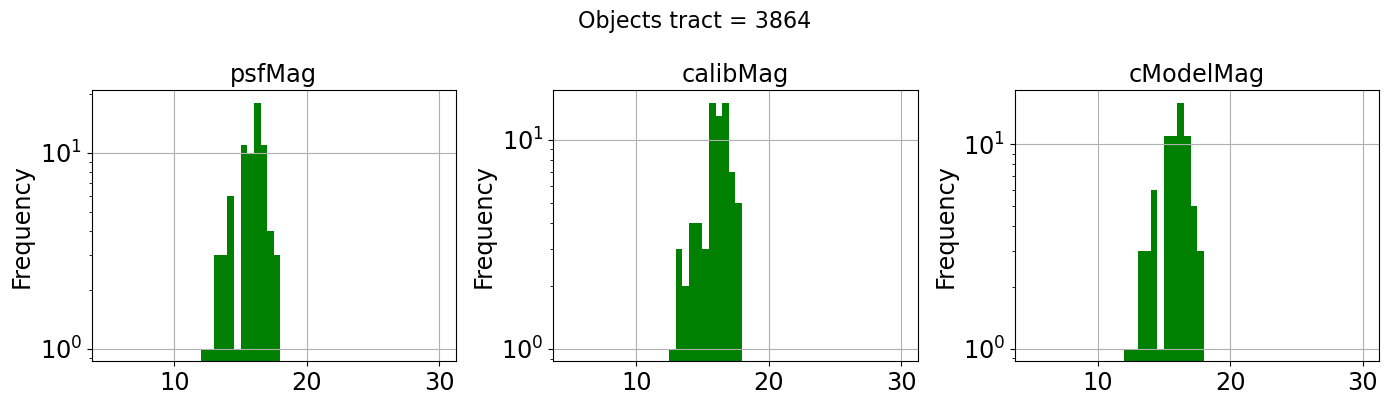

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["g_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['g_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

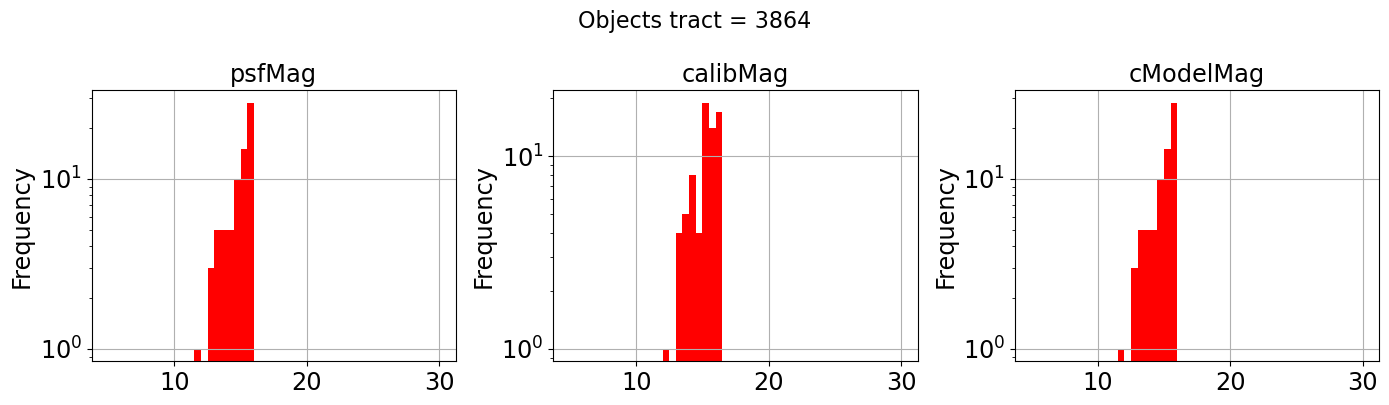

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["r_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['r_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

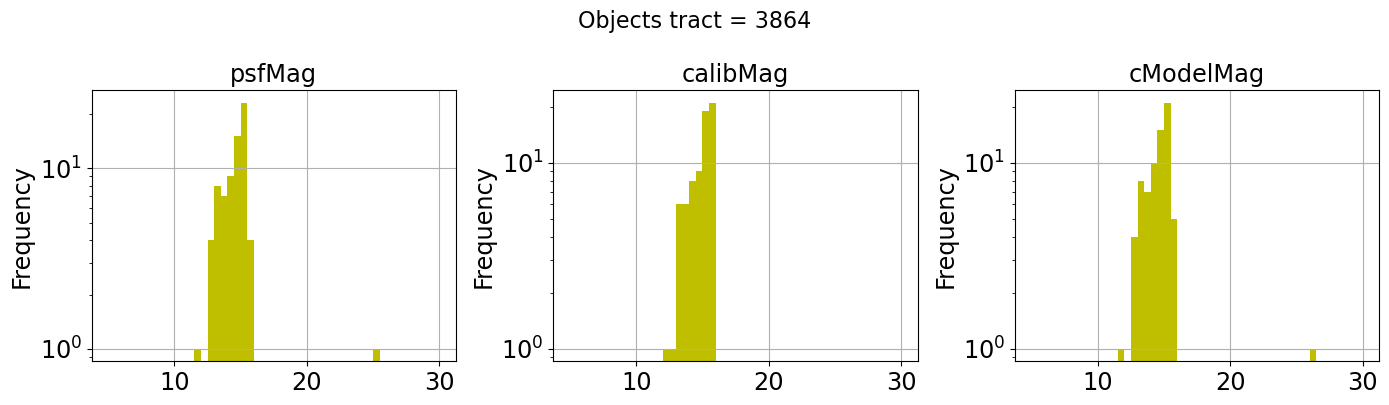

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["i_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['i_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

Text(0.5, 0.98, 'Objects tract = 3864')

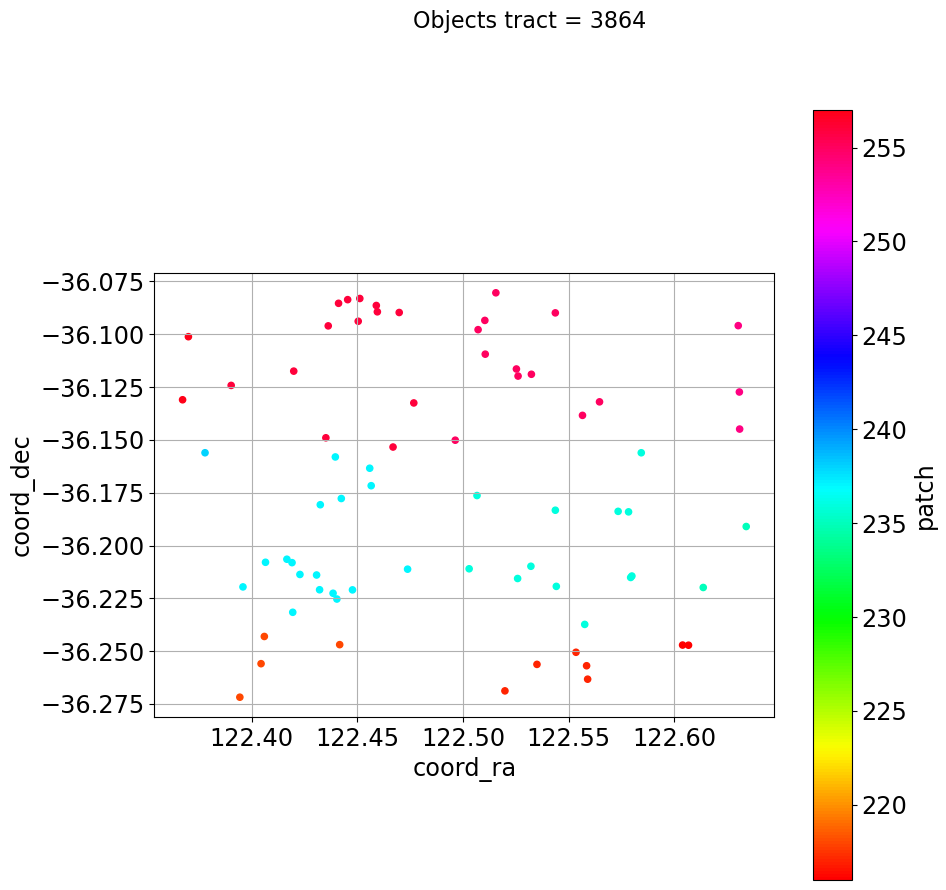

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_sel.plot.scatter('coord_ra','coord_dec',c='patch',colormap='hsv',grid=True,ax=ax)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle,fontsize=16)

<Axes: title={'center': 'coord_ra'}, ylabel='Frequency'>

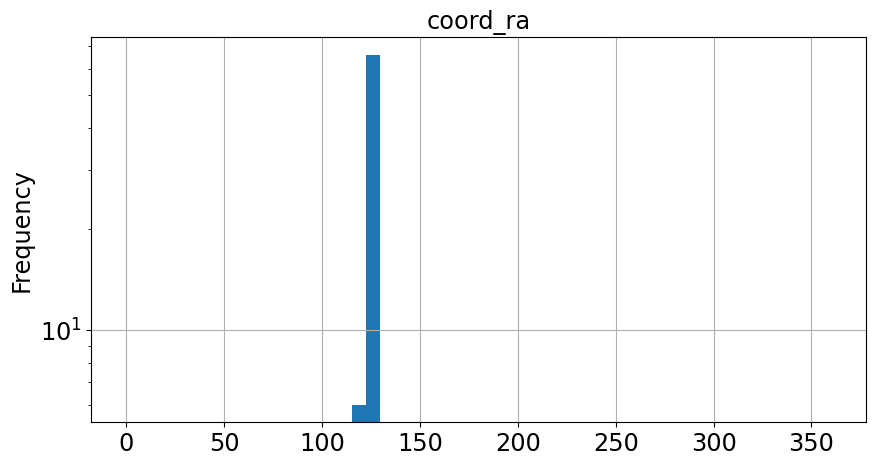

In [18]:
df_sel['coord_ra'].plot(kind="hist",bins=50 ,range=(0,360),logy=True,title="coord_ra",grid=True,figsize=(10,5))

<Axes: title={'center': 'coord_dec'}, ylabel='Frequency'>

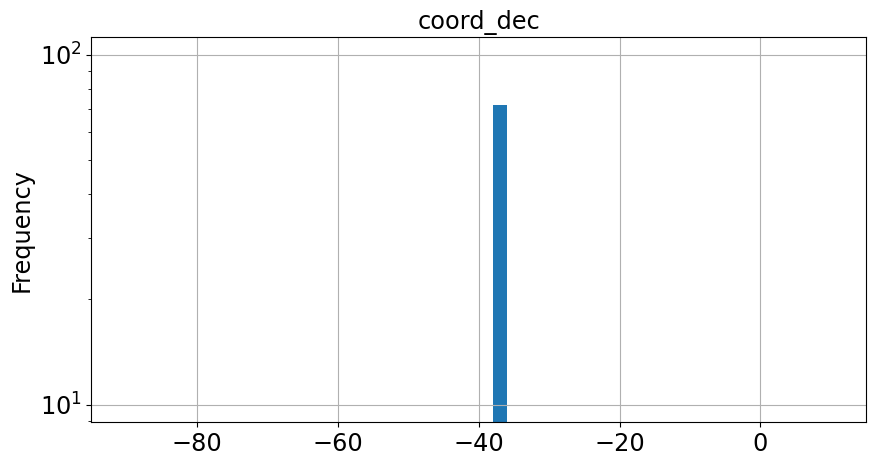

In [19]:
df_sel['coord_dec'].plot(kind="hist",bins=50 ,range=(-90,10),logy=True,title="coord_dec",grid=True,figsize=(10,5))

In [20]:
df_sel["patch"].unique()

array([238, 217, 218, 255, 235, 237, 257, 236, 256, 254, 216])

In [21]:
df_sel = df_sel[ (selection5 | selection6) ]

/tmp/ipykernel_78114/4165971976.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sel = df_sel[ (selection5 | selection6) ]


In [22]:
df_sel.sort_values(by=["r_cModelMag"] ,ascending=True, inplace=True)

/tmp/ipykernel_78114/610645652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.sort_values(by=["r_cModelMag"] ,ascending=True, inplace=True)


In [23]:
df_sel

,objectId,tabid_idx,x,y,coord_ra,coord_dec,tract,patch,refExtendedness,detect_isPrimary,...,i_psfMag,g_calibMag,r_calibMag,i_calibMag,g_cModelMag,r_cModelMag,i_cModelMag,g_kronMag,r_kronMag,i_kronMag
68599,1533973751887038391,113,28390.070185,36453.323392,122.440299,-36.225329,3864,237,0.0,True,...,12.792883,13.085989,13.078246,13.137255,12.784209,12.787088,12.799842,12.792795,12.801727,12.824886
72589,1533972652375410567,116,24351.172813,36817.376966,122.579354,-36.215131,3864,236,0.0,True,...,13.029752,13.539907,13.337421,13.336544,13.256397,13.074178,13.036696,13.259978,13.086289,13.055797
72226,1533972652375410204,116,24983.730621,36018.600838,122.557610,-36.237343,3864,236,0.0,True,...,13.261359,14.085237,13.660293,13.575853,13.798917,13.394525,13.262225,13.796489,13.398998,13.280401
72470,1533972652375410448,116,25373.413272,36667.212856,122.544165,-36.219339,3864,236,0.0,True,...,13.313617,13.964036,13.677853,13.628951,13.669352,13.399749,13.319854,13.679794,13.417009,13.349068
69018,1533973751887038810,113,29077.301157,37131.501332,122.416640,-36.206489,3864,237,0.0,True,...,13.290871,14.102944,13.716602,13.623561,13.786852,13.430721,13.290825,13.797970,13.437668,13.299446
69627,1533973751887039419,113,28411.191861,38874.232881,122.439569,-36.158082,3864,237,0.0,True,...,13.070737,15.499722,14.059621,13.360775,15.186504,13.781076,13.071567,15.188133,13.778422,13.074229
68600,1533973751887038392,113,28442.531374,36551.571803,122.438493,-36.222600,3864,237,0.0,True,...,13.694834,14.715649,14.188769,14.040244,14.404443,13.892393,13.696017,14.420553,13.909127,13.712555
72733,1533972652375410711,116,25722.339778,37010.220359,122.532140,-36.209822,3864,236,0.0,True,...,13.566217,15.718625,14.436199,13.888423,15.426368,14.166358,13.569062,15.438032,14.176009,13.597121
69338,1533973751887039130,113,28618.119943,38060.028916,122.432449,-36.180699,3864,237,0.0,True,...,13.724900,15.783639,14.604070,14.045862,15.473605,14.319190,13.725392,15.479819,14.321032,13.736554
68737,1533973751887038529,113,28175.549875,36609.229843,122.447685,-36.220997,3864,237,0.0,True,...,14.389801,15.210143,14.863220,14.733653,14.890931,14.568098,14.392960,14.913877,14.585256,14.407569


In [24]:
df_sel.to_csv(fileobjects_out)